In [43]:
import pandas as pd
import configparser
import requests
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime, timedelta
import time

In [4]:
# Load credentials from config file
config = configparser.ConfigParser()
config.read('pyalgo.cfg')

consumer_id = config['ssi']['ConsumerID']
consumer_secret = config['ssi']['ConsumerSecret']
private_key = config['ssi']['PrivateKey']

In [5]:
# Step 1: Request access token
def get_access_token(consumer_id, consumer_secret, private_key):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/AccessToken"
    headers = {"Content-Type": "application/json"}
    data = {
        "consumerID": consumer_id,
        "consumerSecret": consumer_secret,
        "privateKey": private_key
    }
    res = requests.post(url, json=data, headers=headers)
    res.raise_for_status()
    response = res.json()

    # Extract access token from response
    if "data" in response and "accessToken" in response["data"]:
        return response["data"]["accessToken"]
    else:
        raise ValueError("Access token not found in response:", response)

# Step 2: Get stock price using access token
def get_stock_price(symbol, token, start_date, end_date):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/DailyStockPrice"
    headers = {
        "Authorization": f"Bearer {token}",
        "Accept": "application/json"
    }
    params = {
        "Symbol": symbol,
        "FromDate": start_date,
        "ToDate": end_date,
        "Market": "HOSE",
        "PageIndex": "1",
        "PageSize": "50"
    }
    res = requests.get(url, headers=headers, params=params)
    res.raise_for_status()
    return res.json()

In [6]:
# Define token
token = get_access_token(consumer_id, consumer_secret, private_key)

In [7]:
stock = pd.DataFrame(columns=['TradingDate', 'ClosePrice'])

# Historical data

In [8]:
symb = 'GAS'
date = datetime.today()

for i in range(20):
    end_date = date.strftime("%d/%m/%Y")
    start_date = (date - timedelta(days=30)).strftime("%d/%m/%Y")
    data = get_stock_price(symb, token, start_date, end_date)
    df = pd.DataFrame(data['data'])

    # Ensure correct types
    df['TradingDate'] = pd.to_datetime(df['TradingDate'], dayfirst=True)
    df['ClosePrice'] = pd.to_numeric(df['ClosePrice'], errors='coerce')
    
    df1 = df.loc[df['Symbol'] == symb, ['TradingDate', 'ClosePrice']]

    # Append to master DataFrame
    stock = pd.concat([stock, df1], ignore_index=True)

    # Adjust date back
    date -= timedelta(days=31)

    # Wait before the next request to respect rate limit
    time.sleep(3)  

/tmp/ipykernel_31011/3811047364.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stock = pd.concat([stock, df1], ignore_index=True)


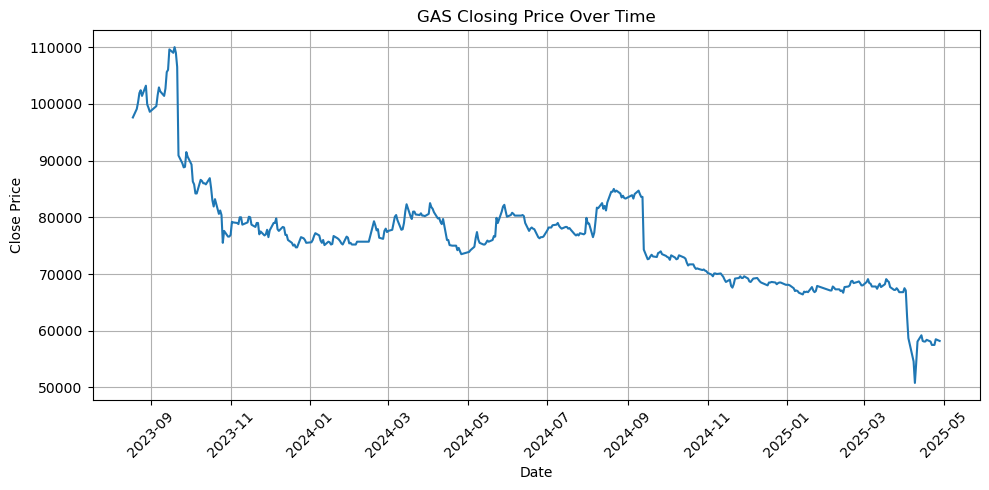

In [9]:
# Sort by trading date
stock = stock.sort_values('TradingDate')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(stock['TradingDate'], stock['ClosePrice'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'{symb} Closing Price Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
stock

,TradingDate,ClosePrice
420,2023-08-18,97600
419,2023-08-21,99100
418,2023-08-22,100300
417,2023-08-23,101900
416,2023-08-24,102400
...,...,...
4,2025-04-22,57500
3,2025-04-23,57500
2,2025-04-24,57500
1,2025-04-25,58500


# Realtime data

In [19]:
# Get realtime stock price and info
def get_rt_stock_price(symbol, token):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/IntradayOhlc"
    headers = {
        "Authorization": f"Bearer {token}",
        "Accept": "application/json"
    }
    params = {
    "symbol": symbol,
    "FromDate": datetime.today().strftime("%d/%m/%Y"),
    "ToDate": datetime.today().strftime("%d/%m/%Y"),
    "PageSize": "50"
    }
    res = requests.get(url, headers=headers, params=params)
    res.raise_for_status()
    return res.json()

In [22]:
rt_stock = get_rt_stock_price('GAS', token)

In [24]:
rt_stock = pd.DataFrame(data['data'])
rt_stock

,Symbol,Value,TradingDate,Time,Open,High,Low,Close,Volume
0,GAS,58200,28/04/2025,13:09:44,58100,58200,58100,58200,300
1,GAS,58100,28/04/2025,13:08:34,58100,58100,58100,58100,200
2,GAS,58100,28/04/2025,13:06:29,58300,58300,58100,58100,1100
3,GAS,58200,28/04/2025,13:05:13,58200,58200,58200,58200,1200
4,GAS,58200,28/04/2025,13:04:49,58200,58200,58200,58200,1500
5,GAS,58200,28/04/2025,13:03:53,58200,58200,58200,58200,1000
6,GAS,58200,28/04/2025,13:02:45,58200,58200,58200,58200,100
7,GAS,58100,28/04/2025,13:00:41,58200,58300,58100,58100,2300
8,GAS,58200,28/04/2025,11:28:05,58200,58200,58200,58200,700
9,GAS,58100,28/04/2025,11:26:57,58100,58100,58100,58100,500


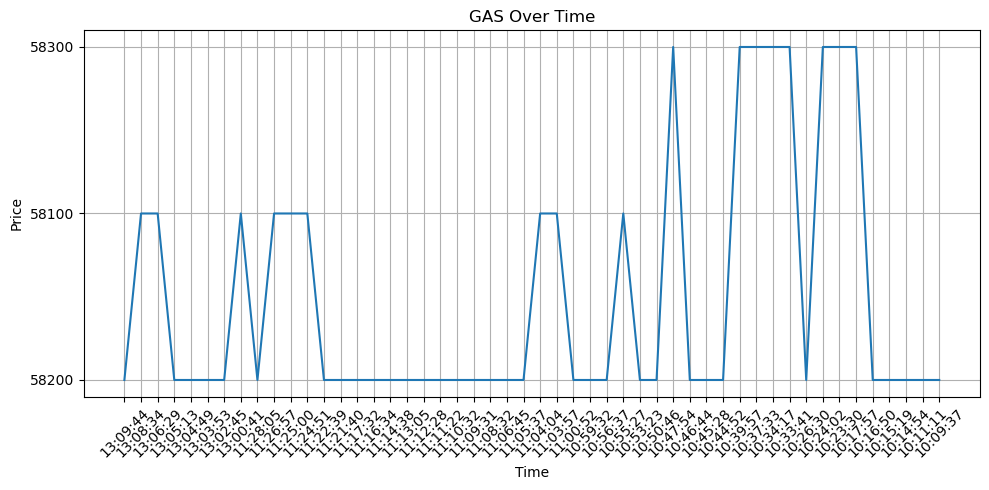

In [27]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(rt_stock['Time'], rt_stock['Close'])
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'GAS Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
t = None
while True:
    rt = get_rt_stock_price('GAS', token)
    if t == None or rt['data'][0]['Time'] != t:
        print(rt['data'][0])
    t = rt['data'][0]['Time']
    time.sleep(2)

{'Symbol': 'GAS', 'Value': '58200', 'TradingDate': '28/04/2025', 'Time': '13:32:08', 'Open': '58200', 'High': '58200', 'Low': '58200', 'Close': '58200', 'Volume': '1600'}


AttributeError: 'str' object has no attribute 'sleep'

In [37]:
fig = go.FigureWidget()
fig.add_scatter()
fig

FigureWidget({
    'data': [{'type': 'scatter', 'uid': '3617f395-9edb-46e7-a560-a6bc01bb1483'}], 'layout': {'template': '...'}
})

In [38]:
times = list()
prices = list()

for _ in range(75):
    rt = get_rt_stock_price('GAS', token)
    t = rt['data'][0]['Time']
    times.append(t)  
    price = rt['data'][0]['Close']
    prices.append(int(price))
    fig.data[0].x = times  
    fig.data[0].y = prices  
    time.sleep(2)

KeyboardInterrupt: 